In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import cv2
from PIL import Image
import pandas as pd

from google.colab import userdata

account_name = userdata.get('storage_account_name')
account_key = userdata.get('storage_account_key')
container_name = userdata.get('blob_container_name')


try:
  %tensorflow_version 2.x
except Exception:
  pass

!pip install tensorflow-io
!pip install azure-storage-blob azure-identity


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load Datasets from Azure Storage



In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient

connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)


# from azure.storage.blob import BlockBlobService

# block_blob_service = BlockBlobService(account_name, account_key)

In [ ]:
import os
import tensorflow as tf
import tensorflow_io as tfio


# Colab Azure QuickStart Guide: https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/azure.ipynb#scrollTo=Read_and_write_files_to_Azure_Storage_with_TensorFlow
os.environ['TF_AZURE_STORAGE_KEY'] = account_key
# Azure Storage Account Name

# list files and directories in storage container
tf.io.gfile.listdir(f'az://{account_name}/{container_name}')

['Sanity2.txt',
 '170418_175706_183328_All_Frames',
 '20170418',
 '20170422',
 '20170508',
 '20170512',
 '20170514',
 '60fps_v1',
 'aztest',
 'blob_connection_check_demo',
 'optical_flow',
 'sample_data_may12_2017']

### Load Azure 60 fps Images directory

In [ ]:
# First let's find the 60 fps video directory in Azure Storage
# {storage blob container name} / 60fps_v1 / 20170418 / 170418_175706_183328_frames

frames_list = tf.io.gfile.listdir(f'az://{account_name}/{container_name}/60fps_v1/20170418/170418_175706_183328_frames')
frames_list = sorted(frames_list)
frames_list[:5]

['20170418_175706_frame_0.jpg',
 '20170418_175706_frame_1.jpg',
 '20170418_175706_frame_10.jpg',
 '20170418_175706_frame_11.jpg',
 '20170418_175706_frame_12.jpg']

Above you can see the first 5 files from the frames directory

In [ ]:
# get datetime column, get frame # column
frame_nums = []
date_strings = []
time_strings = []
for filename in frames_list:
  frame_nums.append(int(filename.split('_')[-1].split('.')[0]))
  date_strings.append(filename.split('_')[0])
  time_strings.append(filename.split('_')[1])

frame_map_df = pd.DataFrame({'frames_filename': frames_list,
                             'frame_num': frame_nums,
                             'Date': date_strings,
                             'Time': time_strings})
frame_map_df['DateTime'] = pd.to_datetime(frame_map_df['Date'] + frame_map_df['Time'], format='%Y%m%d%H%M%S')

frame_map_df.sort_values('frame_num', inplace=True)
frame_map_df.head()


frames_filename  frame_num      Date    Time  \
0   20170418_175706_frame_0.jpg          0  20170418  175706   
1   20170418_175706_frame_1.jpg          1  20170418  175706   
12  20170418_175706_frame_2.jpg          2  20170418  175706   
23  20170418_175706_frame_3.jpg          3  20170418  175706   
34  20170418_175706_frame_4.jpg          4  20170418  175706   

              DateTime  
0  2017-04-18 17:57:06  
1  2017-04-18 17:57:06  
12 2017-04-18 17:57:06  
23 2017-04-18 17:57:06  
34 2017-04-18 17:57:06

Above you can see the frame filename, the frame number in a seperate column which is needed to make it easier for Lucas_Kanade functions to iterate through frames, and DateTime which is in the seconds space and not milliseconds.

In [ ]:
# map each frame to nearest aircraft metadata info
blob_name = f'20170418/IWG1.18Apr2017-2321_processed_170418_175706_170418_230811.csv'
blob_client = container_client.get_blob_client(blob_name)

aircraft_df = pd.read_csv(blob_client.download_blob())
aircraft_df.head()

Short_Name             DateTime_UTC        Lat        Lon  GPS_MSL_Alt  \
0       IWG1  2017-04-18 17:57:06.004  34.605530 -86.583990      19970.3   
1       IWG1  2017-04-18 17:57:07.004  34.607351 -86.583990      19970.1   
2       IWG1  2017-04-18 17:57:08.004  34.609173 -86.583989      19969.8   
3       IWG1  2017-04-18 17:57:09.004  34.610995 -86.583988      19969.6   
4       IWG1  2017-04-18 17:57:10.004  34.612817 -86.583987      19969.4   

   WGS_84_Alt  Press_Alt  Radar_Alt  Grnd_Spd  True_Airspeed  ...  \
0     19970.4    65040.0        NaN     202.7          200.4  ...   
1     19970.3    65042.5        NaN     202.7          200.6  ...   
2     19970.1    65045.0        NaN     202.8          200.9  ...   
3     19969.8    65045.0        NaN     202.8          201.0  ...   
4     19969.6    65037.5        NaN     202.8          200.7  ...   

   Dynamic_Press  Cabin_Pressure  Wind_Speed  Wind_Dir  Vert_Wind_Spd  \
0           21.1           308.6         3.9     232.8            NaN   
1           21.1           309.5         3.9     232.7            NaN   
2           21.2           308.4         3.7     235.9            NaN   
3           21.2           309.4         3.7     236.4            NaN   
4           21.2           309.4         3.7     236.4            NaN   

   Solar_Zenith  Sun_Elev_AC  Sun_Az_Grd  Sun_Az_AC      timestamp  
0          23.7         67.4      -173.6     -172.6  170418_175706  
1          23.7         67.4      -173.6     -172.7  170418_175707  
2          23.7         67.3      -173.6     -172.6  170418_175708  
3          23.7         67.3      -173.6     -172.5  170418_175709  
4          23.7         67.4      -173.6     -172.5  170418_175710  

[5 rows x 34 columns]

The airplane data could be pre-processed to include milliseconds but using Yash's pre-processing script we are taking the first plane data entry per second

### Aircraft Data Load

In [ ]:
# round down for milliseconds so we can work in seconds space for datetime and join the tables

aircraft_df['DateTime'] = pd.to_datetime(aircraft_df['DateTime_UTC']).dt.floor('S')
aircraft_df.head()

<ipython-input-48-8cd74a18c2f0>:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aircraft_df['DateTime'] = pd.to_datetime(aircraft_df['DateTime_UTC']).dt.floor('S')


Short_Name             DateTime_UTC        Lat        Lon  GPS_MSL_Alt  \
0       IWG1  2017-04-18 17:57:06.004  34.605530 -86.583990      19970.3   
1       IWG1  2017-04-18 17:57:07.004  34.607351 -86.583990      19970.1   
2       IWG1  2017-04-18 17:57:08.004  34.609173 -86.583989      19969.8   
3       IWG1  2017-04-18 17:57:09.004  34.610995 -86.583988      19969.6   
4       IWG1  2017-04-18 17:57:10.004  34.612817 -86.583987      19969.4   

   WGS_84_Alt  Press_Alt  Radar_Alt  Grnd_Spd  True_Airspeed  ...  \
0     19970.4    65040.0        NaN     202.7          200.4  ...   
1     19970.3    65042.5        NaN     202.7          200.6  ...   
2     19970.1    65045.0        NaN     202.8          200.9  ...   
3     19969.8    65045.0        NaN     202.8          201.0  ...   
4     19969.6    65037.5        NaN     202.8          200.7  ...   

   Cabin_Pressure  Wind_Speed  Wind_Dir  Vert_Wind_Spd  Solar_Zenith  \
0           308.6         3.9     232.8            NaN          23.7   
1           309.5         3.9     232.7            NaN          23.7   
2           308.4         3.7     235.9            NaN          23.7   
3           309.4         3.7     236.4            NaN          23.7   
4           309.4         3.7     236.4            NaN          23.7   

   Sun_Elev_AC  Sun_Az_Grd  Sun_Az_AC      timestamp            DateTime  
0         67.4      -173.6     -172.6  170418_175706 2017-04-18 17:57:06  
1         67.4      -173.6     -172.7  170418_175707 2017-04-18 17:57:07  
2         67.3      -173.6     -172.6  170418_175708 2017-04-18 17:57:08  
3         67.3      -173.6     -172.5  170418_175709 2017-04-18 17:57:09  
4         67.4      -173.6     -172.5  170418_175710 2017-04-18 17:57:10  

[5 rows x 35 columns]

In [ ]:
frame_map_df.shape

(131044, 5)

In [ ]:
aircraft_df.shape

(18665, 35)

In [ ]:
# flight metadata dataframe already dropped rows where plane is turning from the pre-processing script
# Let's do inner join so we drop image frames where plane is turning
df = pd.merge(frame_map_df, aircraft_df, left_on='DateTime', right_on='DateTime', how='inner')
df.head()

frames_filename  frame_num      Date    Time  \
0  20170418_175706_frame_0.jpg          0  20170418  175706   
1  20170418_175706_frame_1.jpg          1  20170418  175706   
2  20170418_175706_frame_2.jpg          2  20170418  175706   
3  20170418_175706_frame_3.jpg          3  20170418  175706   
4  20170418_175706_frame_4.jpg          4  20170418  175706   

             DateTime Short_Name             DateTime_UTC       Lat       Lon  \
0 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
1 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
2 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
3 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
4 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   

   GPS_MSL_Alt  ...  Dynamic_Press  Cabin_Pressure  Wind_Speed  Wind_Dir  \
0      19970.3  ...           21.1           308.6         3.9     232.8   
1      19970.3  ...           21.1           308.6         3.9     232.8   
2      19970.3  ...           21.1           308.6         3.9     232.8   
3      19970.3  ...           21.1           308.6         3.9     232.8   
4      19970.3  ...           21.1           308.6         3.9     232.8   

   Vert_Wind_Spd  Solar_Zenith  Sun_Elev_AC  Sun_Az_Grd  Sun_Az_AC  \
0            NaN          23.7         67.4      -173.6     -172.6   
1            NaN          23.7         67.4      -173.6     -172.6   
2            NaN          23.7         67.4      -173.6     -172.6   
3            NaN          23.7         67.4      -173.6     -172.6   
4            NaN          23.7         67.4      -173.6     -172.6   

       timestamp  
0  170418_175706  
1  170418_175706  
2  170418_175706  
3  170418_175706  
4  170418_175706  

[5 rows x 39 columns]

In [ ]:
df.shape

(131044, 39)

In [ ]:
df.columns

Index(['frames_filename', 'frame_num', 'Date', 'Time', 'DateTime',
       'Short_Name', 'DateTime_UTC', 'Lat', 'Lon', 'GPS_MSL_Alt', 'WGS_84_Alt',
       'Press_Alt', 'Radar_Alt', 'Grnd_Spd', 'True_Airspeed',
       'Indicated_Airspeed', 'Mach_Number', 'Vert_Velocity', 'True_Hdg',
       'Track', 'Drift', 'Pitch', 'Roll', 'Side_slip', 'Angle_of_Attack',
       'Ambient_Temp', 'Dew_Point', 'Total_Temp', 'Static_Press',
       'Dynamic_Press', 'Cabin_Pressure', 'Wind_Speed', 'Wind_Dir',
       'Vert_Wind_Spd', 'Solar_Zenith', 'Sun_Elev_AC', 'Sun_Az_Grd',
       'Sun_Az_AC', 'timestamp'],
      dtype='object')

The data will have 60 frames per second and the aircraft metadata should be the same across all 60 frame per second after the join.

### LiDAR Data Load

In [ ]:
# add lidar to rows where roughly available

blob_name = f'20170418/goesrplt_CPL_layers_17927_20170418_processed.txt'
blob_client = container_client.get_blob_client(blob_name)

lidar_df = pd.read_csv(blob_client.download_blob())
lidar_df.tail()

date timestamp      lat      lon    alt  angle  N   GH  \
3636  2017-04-18  22:29:31  34.5723 -85.1013  19966  12.76  2 -999   
3637  2017-04-18  22:29:36  34.5652 -85.0937  19996   9.61  2 -999   
3638  2017-04-18  22:29:41  34.5579 -85.0865  19996   7.34  2  300   
3639  2017-04-18  22:29:46  34.5505 -85.0797  19996   5.58  2  300   
3640  2017-04-18  22:29:50  34.5444 -85.0744  19966   4.42  1  300   

      top_height  bottom_height  layer_discriminator  angle_diff_to_prev  
3636       13041          10313                    3               -4.93  
3637       13041          10133                    3               -3.15  
3638       13041          10223                    3               -2.27  
3639       13071          10133                    3               -1.76  
3640       13101          10163                    3               -1.16

In [ ]:
lidar_df['DateTime'] = pd.to_datetime(lidar_df['date'] + ' ' + lidar_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
lidar_df.head()

date timestamp      lat      lon    alt  angle  N   GH  top_height  \
0  2017-04-18  17:22:09  32.8087 -85.3761  17268   0.91  3 -999       13251   
1  2017-04-18  17:22:14  32.8111 -85.3864  17298   0.91  4  180       13281   
2  2017-04-18  17:22:19  32.8135 -85.3966  17328   0.85  3  240       13311   
3  2017-04-18  17:22:24  32.8158 -85.4069  17358   0.79  2  240       13521   
4  2017-04-18  17:22:29  32.8181 -85.4170  17388   0.77  2  270       13551   

   bottom_height  layer_discriminator  angle_diff_to_prev            DateTime  
0          11572                    3                0.10 2017-04-18 17:22:09  
1          11572                    3                0.00 2017-04-18 17:22:14  
2          11572                    3               -0.06 2017-04-18 17:22:19  
3          11422                    3               -0.06 2017-04-18 17:22:24  
4          11003                    3               -0.02 2017-04-18 17:22:29

In [ ]:
full_df = pd.merge(df, lidar_df, left_on='DateTime', right_on='DateTime', how='left')
full_df.head()

frames_filename  frame_num      Date    Time  \
0  20170418_175706_frame_0.jpg          0  20170418  175706   
1  20170418_175706_frame_1.jpg          1  20170418  175706   
2  20170418_175706_frame_2.jpg          2  20170418  175706   
3  20170418_175706_frame_3.jpg          3  20170418  175706   
4  20170418_175706_frame_4.jpg          4  20170418  175706   

             DateTime Short_Name             DateTime_UTC       Lat       Lon  \
0 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
1 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
2 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
3 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   
4 2017-04-18 17:57:06       IWG1  2017-04-18 17:57:06.004  34.60553 -86.58399   

   GPS_MSL_Alt  ...  lat  lon  alt  angle   N  GH  top_height  bottom_height  \
0      19970.3  ...  NaN  NaN  NaN    NaN NaN NaN         NaN            NaN   
1      19970.3  ...  NaN  NaN  NaN    NaN NaN NaN         NaN            NaN   
2      19970.3  ...  NaN  NaN  NaN    NaN NaN NaN         NaN            NaN   
3      19970.3  ...  NaN  NaN  NaN    NaN NaN NaN         NaN            NaN   
4      19970.3  ...  NaN  NaN  NaN    NaN NaN NaN         NaN            NaN   

   layer_discriminator  angle_diff_to_prev  
0                  NaN                 NaN  
1                  NaN                 NaN  
2                  NaN                 NaN  
3                  NaN                 NaN  
4                  NaN                 NaN  

[5 rows x 51 columns]

Lidar is only available roughly every 5 seconds, so most rows will not have a corresponding Lidar truth

## Lucas_Kanade Tracking and Height Calculation

In [ ]:
def Lucas_Kanade_OF(img1, img2, start_x, start_y, x, next):
    Ix = np.zeros([x, x])
    It = np.zeros([x, x])

    for i in range(start_x, start_x+x):
        for j in range(start_y, start_y+x):
            Ix[i-start_x, j-start_y] = ((int(img1[i+next,j])+int(img2[i+next,j])+int(img1[i+next,j+next])+int(img2[i+next,j+next]))-(int(img1[i,j])+int(img2[i,j])+int(img1[i,j+next])+int(img2[i,j+next])))/4
            It[i-start_x, j-start_y] = -((int(img2[i,j])+int(img2[i+next,j])+int(img2[i,j+next])+int(img2[i+next,j+next]))-(int(img1[i,j])+int(img1[i+next,j])+int(img1[i,j+next])+int(img1[i+next,j+next])))/4

    A = Ix.reshape(x*x)
    A = np.array(A)
    B = np.array(It.reshape(x*x))

    if sum(A*A) != 0:
        u = sum(A*B)/sum(A*A)
    else:
        u = 0
    return u

In [ ]:
def get_frame_filepath(frame_number, mapping_df=full_df):
    #TF Versions
    file_name = full_df[full_df['frame_num'] == frame_number].frames_filename.iloc[0]
    #file_path = f'az://{account_name}/{container_name}/60fps_v1/20170418/170418_175706_183328_frames/{file_name}'
    file_path = f'60fps_v1/20170418/170418_175706_183328_frames/{file_name}'

    return file_path

def get_image_from_blob(frame_number, mapping_df=full_df):
    blobpath = get_frame_filepath(frame_number)
    print(blobpath)

    # use numpy to construct an array from the bytes
    client = BlobClient.from_connection_string(connection_string, container_name, blobpath)
    blob = client.download_blob().readall()
    x = np.fromstring(blob, dtype='uint8')

    # decode the array into an image
    img = cv2.imdecode(x, cv2.IMREAD_GRAYSCALE)
    return img


In [ ]:
import numpy as np
import cv2

def get_next(image_folder, first_frame, x, y, w_size):
    img1 = get_image_from_blob(first_frame)

    for i in range(first_frame+1,131000):
        #print(i)
        img2 = get_image_from_blob(int(i+1))

        for r in range(10):
            u = Lucas_Kanade_OF(img1, img2, x, y, w_size, r+1)
            if u > 0.9:
                break

        if u>=0.9:
            #print(i, u, x, r)
            break


    return i,u, r

In [ ]:
def get_OF(image_folder, first_frame, x, y, w_size = 5):
    change = 0
    first_frame_org = first_frame

    try:
        while first_frame<first_frame_org+600 and x<1000-w_size and change<50:
            old_frame = first_frame
            first_frame, u, r = get_next(image_folder, first_frame, x, y, w_size)
            x = x + r + round(u)
            change = first_frame - old_frame
    except:
        pass

    return x, first_frame

In [ ]:
def get_speed(diam, frame_pixels, first_pixel, last_pixel, first_frame, last_frame):
    print("first pixel: ", first_pixel)
    print("last pixel: ", last_pixel)
    travelled_pixels = last_pixel - first_pixel
    travel_time = (last_frame - first_frame)/60

    travelled_distance = travelled_pixels * diam/frame_pixels
    u = travelled_distance/travel_time

    return u

In [ ]:
def get_height(x, y, first_frame, diam, frame_pixels, pitch, input_folder):
    x_l, frame_l = get_OF(input_folder, first_frame, x, y, 12)
    u = get_speed(diam, frame_pixels, x, x_l, first_frame, frame_l)
    print(u)
    height = (h - f*v/u)*math.cos(math.pi*pitch/180)
    return(height)

### Test loading image

60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


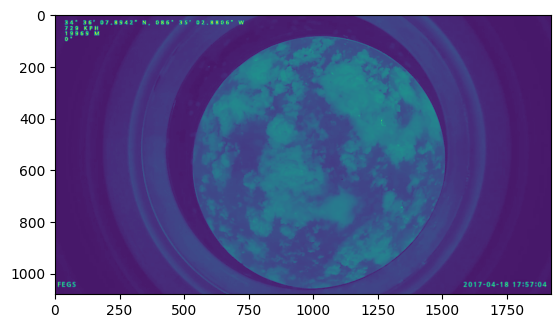

In [ ]:
# find central box of image

# Create a DataFrame from the image
img = get_image_from_blob(0)

# displaying image
plt.imshow(img)
plt.show()

60fps_v1/20170418/170418_175706_183328_frames/20170418_180706_frame_36000.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


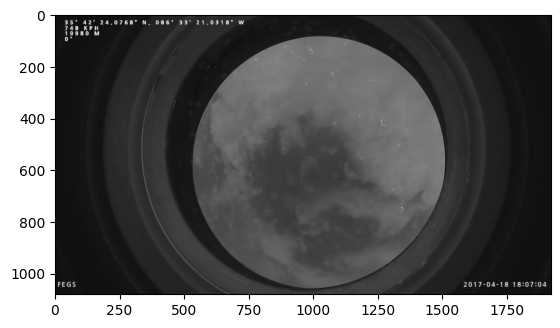

In [ ]:
# Create a DataFrame from the image
img = get_image_from_blob(36000)

# displaying image
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
print(full_df.columns)

Index(['frames_filename', 'frame_num', 'Date', 'Time', 'DateTime',
       'Short_Name', 'DateTime_UTC', 'Lat', 'Lon', 'GPS_MSL_Alt', 'WGS_84_Alt',
       'Press_Alt', 'Radar_Alt', 'Grnd_Spd', 'True_Airspeed',
       'Indicated_Airspeed', 'Mach_Number', 'Vert_Velocity', 'True_Hdg',
       'Track', 'Drift', 'Pitch', 'Roll', 'Side_slip', 'Angle_of_Attack',
       'Ambient_Temp', 'Dew_Point', 'Total_Temp', 'Static_Press',
       'Dynamic_Press', 'Cabin_Pressure', 'Wind_Speed', 'Wind_Dir',
       'Vert_Wind_Spd', 'Solar_Zenith', 'Sun_Elev_AC', 'Sun_Az_Grd',
       'Sun_Az_AC', 'timestamp_x', 'date', 'timestamp_y', 'lat', 'lon', 'alt',
       'angle', 'N', 'GH', 'top_height', 'bottom_height',
       'layer_discriminator', 'angle_diff_to_prev'],
      dtype='object')


In [ ]:
print("Ground Speed", full_df['Grnd_Spd'].iloc[0])
print("Altitude", full_df['GPS_MSL_Alt'].iloc[0])
print("Actual Height", full_df['top_height'].iloc[0])

Ground Speed 202.7
Altitude 19970.3
Actual Height nan


In [ ]:
print("Nearest Lidar Actual Height for Frame 0", full_df['top_height'].dropna().iloc[0])

Nearest Lidar Actual Height for Frame 0 13161.0


### Test Signal Frame Height Prediction

In [ ]:
#pick square in center of frame and run through the function to see if it predicts correctly

x = 509 # x co-ordinate of the point
y = 950 # y co-ordinate of the point
diam = 8 # Diameter of the camera frame
frame_pixels = 1080 # Pixels of the verticle diameter of the camera frame
f = 1.4 # focal length of the camers
v = 202.7 # Velocity of the plane in km/s
h = 19970 # Height of the plane in km
pitch = 0.92

first_frame = 0 # Frame of the video from where the point to be tracked

# Folder in which video frames are saved
try:
      os.mkdir("tmp")
except:
  print("already exists")
input_folder = "tmp"

h = get_height(x, y, first_frame, diam, frame_pixels, pitch, input_folder)
print(h)

already exists
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_2.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_3.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_4.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_5.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_6.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_7.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_6.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_8.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_9.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_10.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_11.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_12.jpg
60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_13.jpg
60fps_v1/20170418/170418_175706_18

In [ ]:
print("Actual Minus Predicted Height (m)", full_df['top_height'].dropna().iloc[0] - h)

Actual Minus Predicted Height (m) -9.101711765588334


We had success picking points to track manually. Can we set a pixel brightness rule to pick cloud points from non-cloud?

### Explore Differences in Pixels Between Sky and Cloud

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

print(len(img))
print(len(img[0]))
all_pixels_vals = []
for i in range(len(img)):
  for j in range(len(img[0])):
    all_pixels_vals.append(img[i][j])

print(len(all_pixels_vals))

1080
1920
2073600


0
255
54.47138213734568


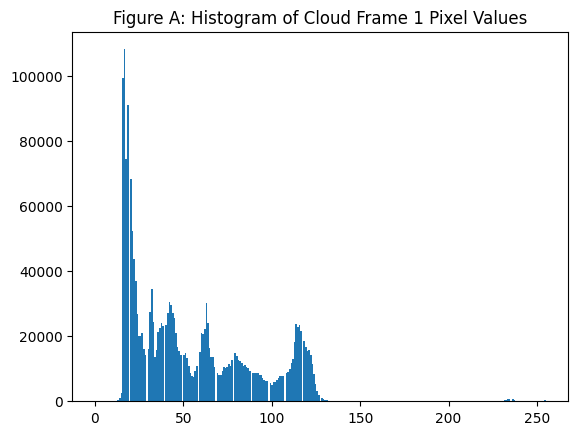

In [ ]:
print(min(all_pixels_vals))
print(max(all_pixels_vals))
print(sum(all_pixels_vals)/ len(all_pixels_vals))

# overall black/white color values in histogram
a = np.hstack(all_pixels_vals)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Figure A: Histogram of Cloud Frame 1 Pixel Values")
plt.show()

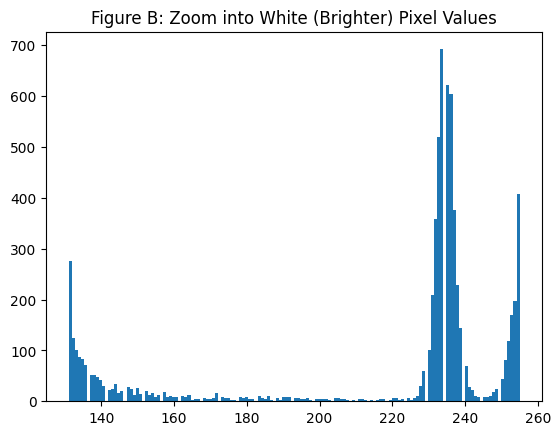

In [ ]:
# Let's zoom into the whiter color ranges
a = np.hstack([x for x in all_pixels_vals if x > 130])
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Figure B: Zoom into White (Brighter) Pixel Values")
plt.show()

60fps_v1/20170418/170418_175706_183328_frames/20170418_180706_frame_36000.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


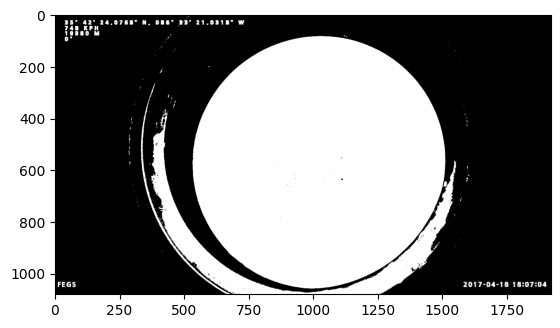

In [ ]:
img = get_image_from_blob(36000)

for i in range(len(img)):
  for j in range(len(img[0])):
    if img[i][j] > 55:
      img[i][j] = 200
    else:
      img[i][j] = 0

plt.imshow(img, cmap='gray')
plt.show()

Probably not, should use model like convnet

### Test Convnext for Feature Extraction

In [ ]:
# TBA function to pick random square to track from convnext

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoImageProcessor, ConvNextModel
from torchvision import transforms
from azure.storage.blob import BlobServiceClient
from PIL import Image, ImageEnhance, ImageOps
import io


WIDTH_OFFSET = 50 # in pixels
HEIGHT_OFFSET = 40 # in pixels

def load_image_from_blob_cv(blob_img):
    """
    Loads the image from the Azure Blob Storage using OpenCV and returns it as a numpy array.
    Args:
        blob_img (str): name of the blob image in the container
    Returns:
        (numpy.ndarray): loaded image in greyscale
    """
    blob_client = container_client.get_blob_client(blob_img)
    streamdownloader = blob_client.download_blob()
    blob_data = streamdownloader.readall()
    image_array = np.asarray(bytearray(blob_data), dtype=np.uint8)
    img_bgr = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb


def crop_image_cv(image, size=(600, 600)):
    h, w = image.shape[:2]
    center_h, center_w = h // 2, w // 2
    start_h = max(center_h - size[0] // 2, 0) + HEIGHT_OFFSET
    start_w = max(center_w - size[1] // 2, 0) + WIDTH_OFFSET
    print('h', h)
    print('w', w)
    print('start_h', start_h)
    print('end_h', start_h + size[0])
    print('start_w', start_w)
    print('end_w', start_w + size[1])
    return image[start_h:start_h + size[0], start_w:start_w + size[1]]


def augment_greyscale_image(img, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=True):
    """
    Augments the Greyscale image to enhance the feature of the cloud. Includes:
      1. Contrast and Brightness
      2. Gaussian Blur
      3. Histogram Equalization
      4. Sharpening
    Args:
        img (numpy.ndarray): greyscale image
        contrast_factor (float): contrast factor
        brightness_beta (int): brightness factor
        kernel_size (tuple): kernel size for Gaussian Blur
        blur (bool): whether to apply Gaussian Blur
    Returns:
        (numpy.ndarray): augmented image
    """
    img_enhanced = cv2.convertScaleAbs(img, alpha=contrast_factor, beta=brightness_beta)
    if blur:
        img_enhanced = cv2.GaussianBlur(img_enhanced, kernel_size, 0)
    img_enhanced = cv2.equalizeHist(img_enhanced)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_enhanced)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img_enhanced, -1, kernel)


# # Approximate K, to be updated when NASA sends us actual values
# fx = fy = 1.4 * image_width / (2 * np.tan(np.radians(185) / 2))
# cx = image_width / 2
# cy = image_height / 2
# K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# # Approximate D, to be updated when NASA sends us actual values
# D = np.array([-0.3, 0.1, 0.0, 0.0])


def undistort_fisheye_image(distorted_image, K, D):
    """
    Apply correction for fisheye distortion.
    Args:
        distorted_image (numpy.ndarray): original image that has the fisheye distortion.
        K (numpy.ndarray): Camera Intrinsic Matrix
        D (numpy.ndarray): Distortion Coeffcients
    """
    h, w = blob_img.shape[:2]
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), None)
    undistorted_img = cv2.fisheye.undistortImage(blob_img, K, D, new_K=new_K)
    return undistorted_img


def visualize_augmentations_cv(image_list, enhance=True, crop=True):
    """
    Visualizes original and augmented greyscale images using OpenCV.
    Args:
        image_list (list): List of image paths in Azure Blob Storage
        enhance (bool): Whether to apply image augmentation
        crop (bool): Whether to apply image cropping
    Returns:
        None
    """
    fig, axes = plt.subplots(len(image_list), 3, figsize=(15, 5 * len(image_list)))

    for idx, blob_img in enumerate(image_list):
        original_image = load_image_from_blob_cv(blob_img)
        greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
        augmented_image = greyscale_image.copy()

        if crop:
            augmented_image = crop_image_cv(augmented_image)

        if enhance:
            augmented_image = augment_greyscale_image(augmented_image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5))

        axes[idx, 0].imshow(original_image)
        axes[idx, 0].set_title("Original Image (RGB)")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(greyscale_image, cmap='gray')
        axes[idx, 1].set_title("Greyscale Image")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(augmented_image, cmap='gray')
        axes[idx, 2].set_title("Augmented Image")
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()


def extract_features(blob_img, model, image_processor, enhance=True, correct_fisheye=False, K=None, D=None):
    """
    Extracts feature maps from the model by:
        - loading, cropping and preprocessing the image using OpenCV
        - forward pass through the model
        - extracting the last hidden state to produce feature maps
    Args:
        blob_img (str): name of the blob image in the container
        model: loaded model
        enhance (bool): whether to apply image augmentation
        correct_fisheye (bool): whether to correct fisheye distortion
        K, D: camera matrix and distortion coefficients for fisheye correction
    Returns:
        (torch.Tensor): feature maps
    """
    image = load_image_from_blob_cv(blob_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if correct_fisheye and K is not None and D is not None:
        image = undistort_fisheye_image(image, K, D)

    image = crop_image_cv(image)

    if enhance:
        image = augment_greyscale_image(image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    inputs = image_processor(image_rgb, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    feature_map = outputs.last_hidden_state

    return feature_map


def extract_gradients(blob_img, model, image_processor, enhance=True, correct_fisheye=False, K=None, D=None):
    """
    Computes gradients from the model by:
        - loading, cropping and preprocessing the image using OpenCV
        - enabling gradient computation
        - forward pass through the model
        - gradient computation
    Args:
        blob_img (str): name of the blob image in the container
        model: loaded model
        enhance (bool): whether to apply image augmentation
    Returns:
        (torch.Tensor): gradients
    """
    image = load_image_from_blob_cv(blob_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if correct_fisheye and K is not None and D is not None:
        image = undistort_fisheye_image(image, K, D)

    image = crop_image_cv(image)

    if enhance:
        image = augment_greyscale_image(image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    inputs = image_processor(image_rgb, return_tensors="pt")
    inputs['pixel_values'].requires_grad_()

    outputs = model(**inputs)

    grad_feature_map = outputs.last_hidden_state

    grad_outputs = torch.ones_like(grad_feature_map)
    gradients = torch.autograd.grad(
        outputs=grad_feature_map,
        inputs=inputs['pixel_values'],
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]

    return gradients


def apply_regularization(model, weight_decay=1e-4):
    """
    Applies L2 regularization to the model.
    Args:
        model: loaded model
        weight_decay (float): regularization parameter
    Returns:
      None
    """
    for param in model.parameters():
        param.data = param.data - weight_decay * param.data


def visualize_feature_maps(image_list, model_list, enhance=True, crop=False, overlay_grad=False):
    """
    Visualizes original images, augmented images, and feature overlays.
    Args:
        image_list (list): List of image paths in Azure Blob Storage
        enhance (bool): Whether to apply image augmentation
        crop (bool): Whether to apply image cropping
        overlay_grad (bool): Whether to overlay gradients on the images
    Returns:
        None
    """
    fig, axes = plt.subplots(len(image_list), 3 + len(model_list), figsize=(4 * len(image_list), 6 * len(image_list)))

    for idx, blob_img in enumerate(image_list):
        original_image = load_image_from_blob_cv(blob_img)
        greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        augmented_image = greyscale_image.copy()
        if crop:
            augmented_image = crop_image_cv(augmented_image)
        if enhance:
            augmented_image = augment_greyscale_image(augmented_image)

        # Display images
        axes[idx, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title("Original Image (RGB)")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(greyscale_image, cmap='gray')
        axes[idx, 1].set_title("Greyscale Image")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(augmented_image, cmap='gray')
        axes[idx, 2].set_title("Augmented Greyscale Image")
        axes[idx, 2].axis('off')

        feature_maps = []
        gradient_maps = []
        for i, model_name in enumerate(model_list):
            image_processor = AutoImageProcessor.from_pretrained(model_name)
            model = ConvNextModel.from_pretrained(model_name)
            model.eval()
            # Extract features and gradients
            gradients = extract_gradients(blob_img, model, image_processor, enhance=False)
            features = extract_features(blob_img, model, image_processor, enhance=False)

            if overlay_grad and gradients is not None:
                summed_gradients = gradients.squeeze().mean(dim=0).detach().numpy()
                summed_gradients = (summed_gradients - summed_gradients.min()) / (summed_gradients.max() - summed_gradients.min())
                summed_gradients_img = Image.fromarray((summed_gradients * 255).astype(np.uint8))
                size = (augmented_image.shape[1], augmented_image.shape[0])
                gradient_map_image = summed_gradients_img.resize(size, resample=Image.BILINEAR)
                gradient_map_image = np.array(gradient_map_image).astype(np.float32)
                #gradient_map_image = np.array(summed_gradients_img).astype(np.float32)


                axes[idx, 3 + i].imshow(augmented_image, cmap='gray')
                axes[idx, 3 + i].imshow(gradient_map_image, cmap='gray', alpha=0.5)
                axes[idx, 3 + i].set_title(f'{model_name.split("/")[1]}')
                axes[idx, 3 + i].axis('off')

                gradient_maps.append(gradient_map_image)
                #feature_maps.append(feature_map_image)

            else:
                summed_feature_map = features.squeeze().mean(dim=0).detach().numpy()
                summed_feature_map = (summed_feature_map - summed_feature_map.min()) / (summed_feature_map.max() - summed_feature_map.min())
                summed_feature_map_img = Image.fromarray((summed_feature_map * 255).astype(np.uint8))
                size = (augmented_image.shape[1], augmented_image.shape[0])
                feature_map_image = summed_feature_map_img.resize(size, resample=Image.BILINEAR)
                feature_map_image = np.array(feature_map_image).astype(np.float32)
                #feature_map_image = np.array(summed_feature_map_img).astype(np.float32)

                axes[idx, 2 + i + 1].imshow(augmented_image)
                axes[idx, 2 + i + 1].imshow(feature_map_image, cmap='jet', alpha=0.5)
                axes[idx, 2 + i + 1].set_title(f'{model_name}'.split('/')[1])
                axes[idx, 2 + i + 1].axis('off')

                feature_maps.append(feature_map_image)


    plt.tight_layout()
    plt.show()
    return feature_maps, gradient_maps

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import AutoImageProcessor, ConvNextModel


def print_pixel_stats(stage, image):
    if isinstance(image, np.ndarray):
        print(f"{stage} - dtype: {image.dtype}, min: {image.min()}, max: {image.max()}, shape: {image.shape}")
    elif isinstance(image, torch.Tensor):
        print(f"{stage} - dtype: {image.dtype}, min: {image.min().item()}, max: {image.max().item()}, shape: {image.shape}")
    else:
        print(f"{stage} - dtype: {image.mode}, shape: {image.size}")
        print(f"{stage} - Pixel values range: {np.array(image).min()} to {np.array(image).max()}")

In [ ]:
model_name = "facebook/convnext-large-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ConvNextModel.from_pretrained(model_name)

model.eval()

#blob_img = "20170418/170418_175706_183328_frames_cropped/20170418_175706_frame_0_cropped.jpg"
blob_img = "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175706_frame_0.jpg"
feature_map = extract_features(blob_img, model, image_processor, enhance=False)
gradients = extract_gradients(blob_img, model, image_processor, enhance=False)

feature_map_enhance = extract_features(blob_img, model, image_processor, enhance=True)
gradients_enhance = extract_gradients(blob_img, model, image_processor, enhance=True)
# apply_regularization(model) not necessary unless fine-tuning

print(f"Feature Map Shape: {feature_map.shape}")
print(f"Feature Map Shape: {feature_map_enhance.shape}")
print(f"Gradients Shape: {gradients.shape}")
print(f"Gradients Shape: {gradients_enhance.shape}")

h 800
w 800
start_h 140
end_h 740
start_w 150
end_w 750
h 800
w 800
start_h 140
end_h 740
start_w 150
end_w 750
h 800
w 800
start_h 140
end_h 740
start_w 150
end_w 750
h 800
w 800
start_h 140
end_h 740
start_w 150
end_w 750
Feature Map Shape: torch.Size([1, 1536, 7, 7])
Feature Map Shape: torch.Size([1, 1536, 7, 7])
Gradients Shape: torch.Size([1, 3, 224, 224])
Gradients Shape: torch.Size([1, 3, 224, 224])


60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


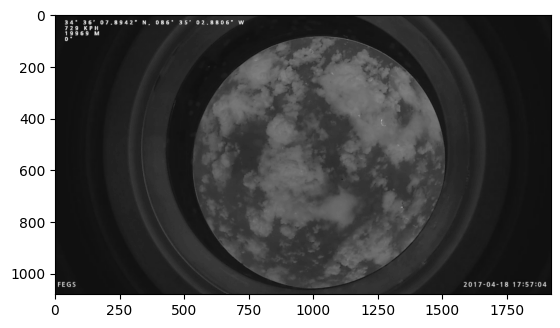

Gray Image - dtype: uint8, min: 0, max: 255, shape: (1080, 1920)


In [ ]:
# find central box of image

# Create a DataFrame from the image
img = get_image_from_blob(0)

# displaying image
plt.imshow(img, cmap='gray')
plt.show()
print_pixel_stats("Gray Image", img)

h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 13

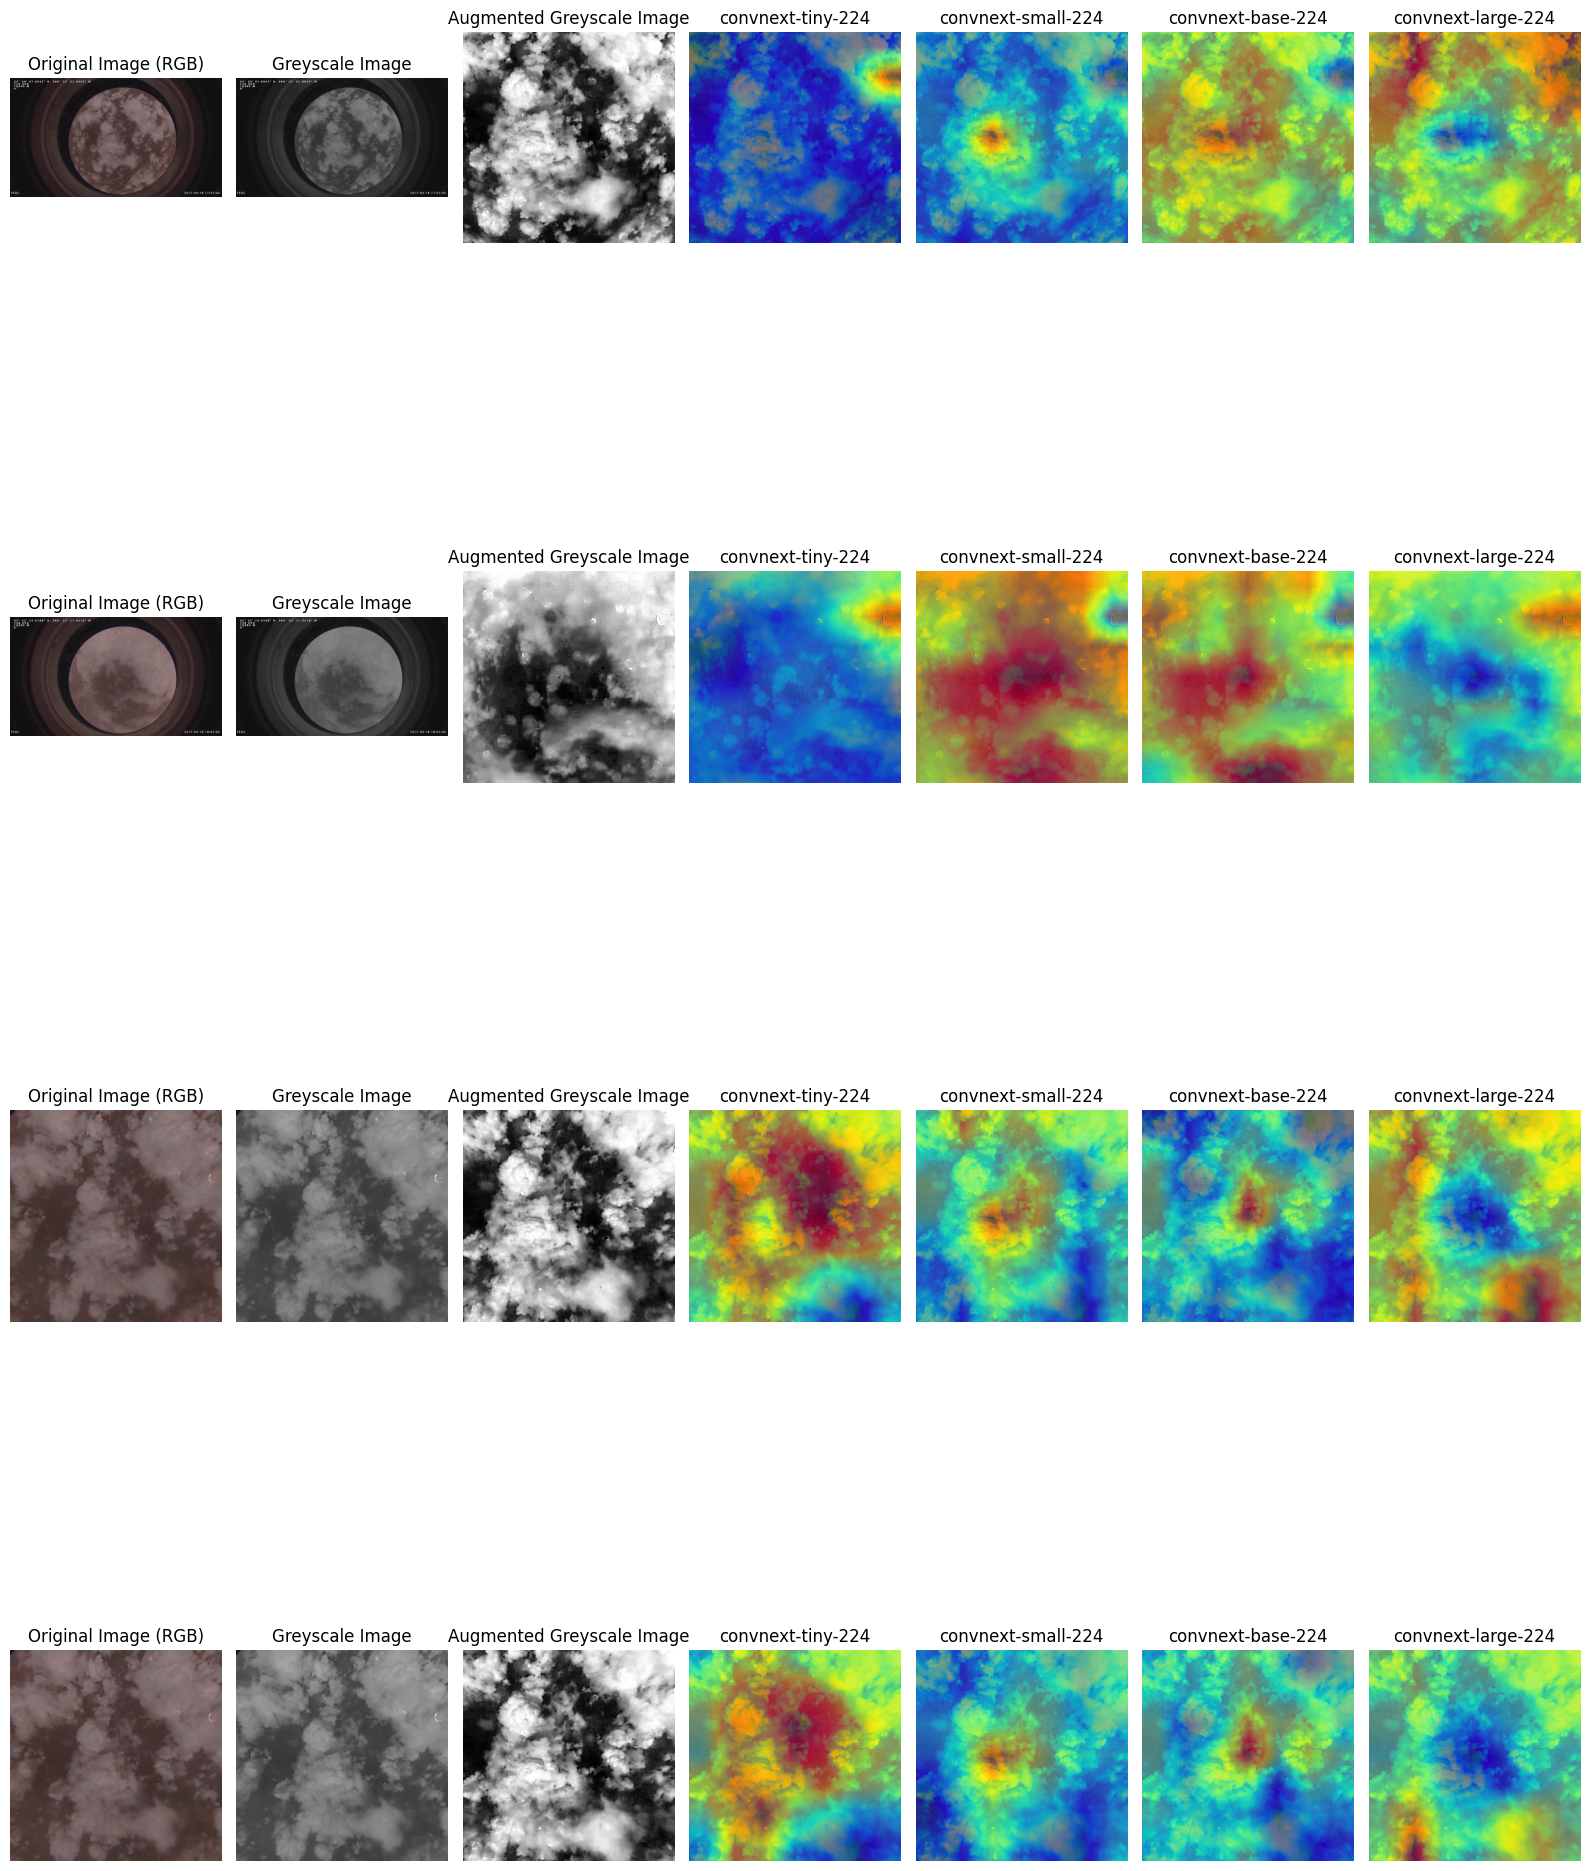

In [ ]:
# images = [
#     "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg",
#     "60fps_v1/20170418/170418_175706_183328_frames/20170418_180706_frame_36000.jpg",
#     "20170418/170418_175706_183328_frames_cropped/20170418_175709_frame_180_cropped.jpg",
#     "20170418/170418_175706_183328_frames_cropped/20170418_175710_frame_240_cropped.jpg",
# ]

images = [
    "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg",
    "60fps_v1/20170418/170418_175706_183328_frames/20170418_180706_frame_36000.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175709_frame_180.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175710_frame_240.jpg",
]

models = [
    "facebook/convnext-tiny-224",
    "facebook/convnext-small-224",
    "facebook/convnext-base-224",
    "facebook/convnext-large-224"
]

#def visualize_feature_maps(image_list, model_list, enhance=True, crop=False, overlay_grad=False):
feature_imgs, gradient_imgs = visualize_feature_maps(images, models, enhance=True, crop=True)

h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 800
w 800
start_h 140
end_h 740
start_w 150
end_w 750


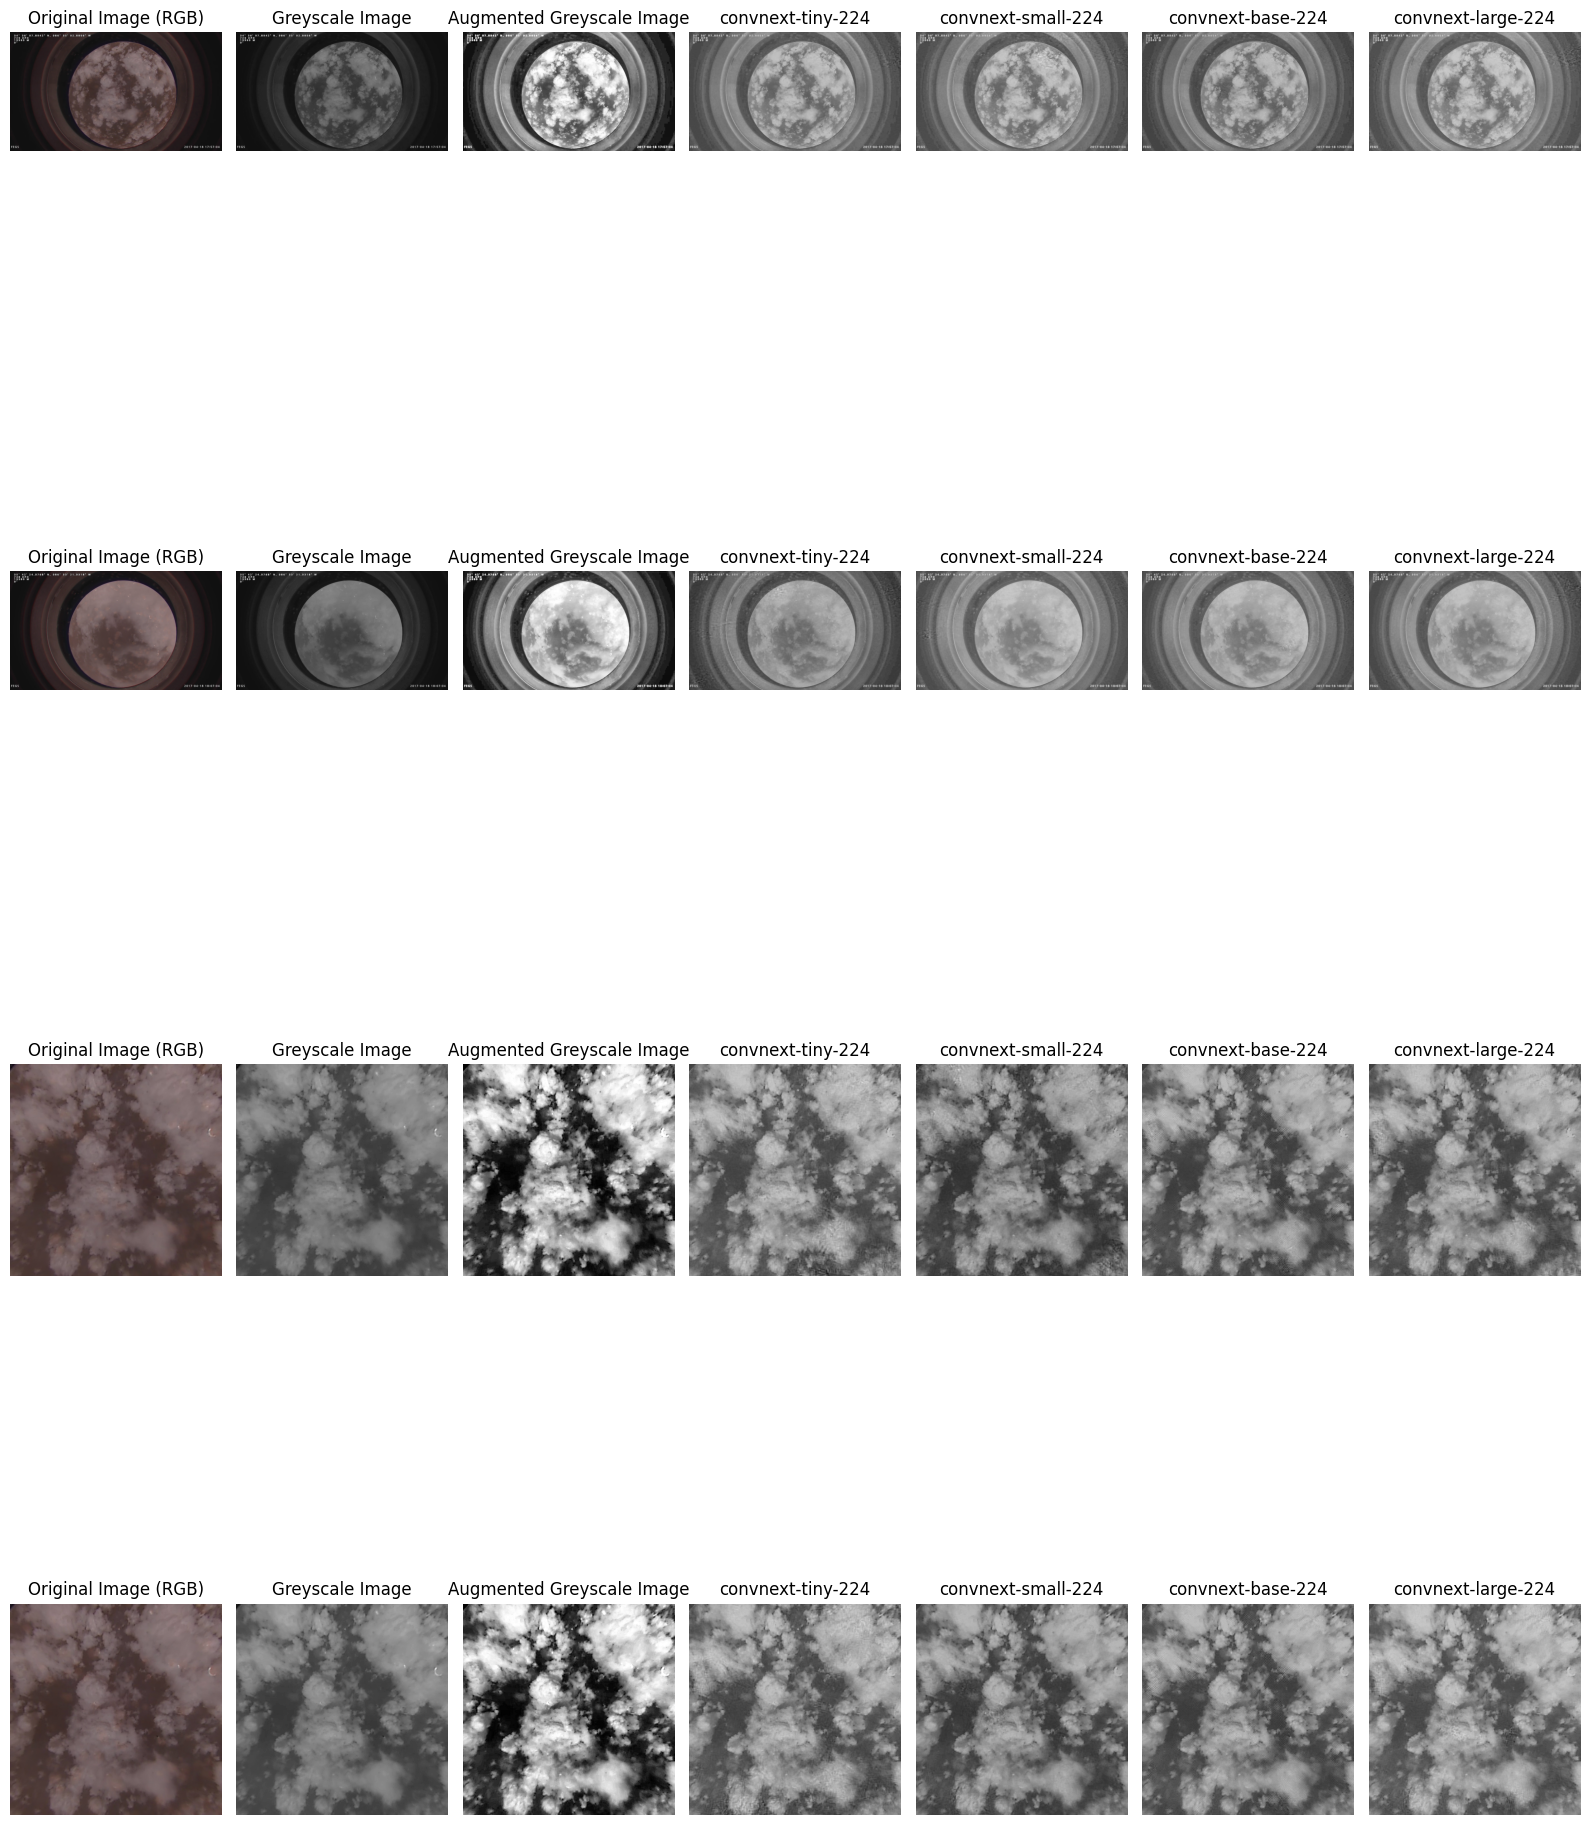

In [ ]:
feature_imgs, gradient_imgs = visualize_feature_maps(image_list=images, model_list=models, enhance=True, crop=False, overlay_grad=True)

In [ ]:
# Next Steps

# Crop image
# max values?

60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


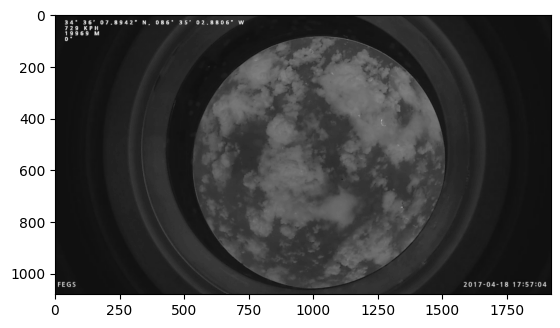

Gray Image - dtype: uint8, min: 0, max: 255, shape: (1080, 1920)


In [ ]:

# Create a DataFrame from the image
img = get_image_from_blob(0)


#img_after = crop_image_cv(img)
# displaying image
plt.imshow(img, cmap='gray')
plt.show()
print_pixel_stats("Gray Image", img)

60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310


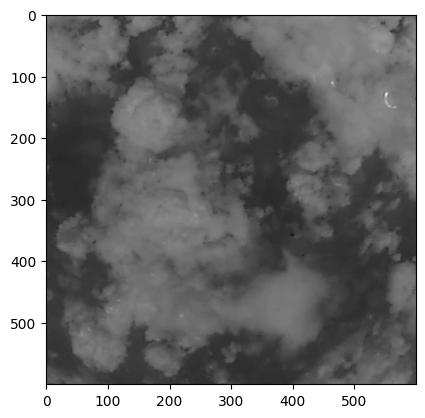

Gray Image - dtype: uint8, min: 0, max: 255, shape: (1080, 1920)


In [ ]:
# find central box of image

# Create a DataFrame from the image
img = get_image_from_blob(0)


img_after = crop_image_cv(img)
# displaying image
plt.imshow(img_after, cmap='gray')
plt.show()
print_pixel_stats("Gray Image", img)

60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


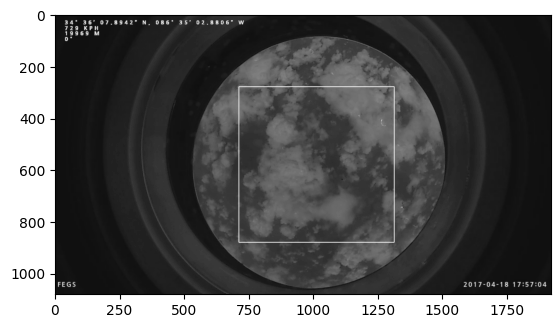

In [ ]:
WIDTH_OFFSET = 50 # in pixels
HEIGHT_OFFSET = 40 # in pixels



# Create a DataFrame from the image
img = get_image_from_blob(0)

# Start coordinate, here (5, 5)
# represents the top left corner of rectangle
start_point = (660+WIDTH_OFFSET, 240 + HEIGHT_OFFSET) # (w, h) (1920, 1080)

# Ending coordinate, here (, 220)
# represents the bottom right corner of rectangle
end_point = (1260 + WIDTH_OFFSET, 840 + HEIGHT_OFFSET)

# Blue color in BGR
color = (255, 0, 0)

# Line thickness of 2 px
thickness = 2

# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image = cv2.rectangle(img, start_point, end_point, color, thickness)

# Displaying the image
plt.imshow(image, cmap = 'gray')
plt.show()

In [ ]:
full_df.columns

Index(['frames_filename', 'frame_num', 'Date', 'Time', 'DateTime',
       'Short_Name', 'DateTime_UTC', 'Lat', 'Lon', 'GPS_MSL_Alt', 'WGS_84_Alt',
       'Press_Alt', 'Radar_Alt', 'Grnd_Spd', 'True_Airspeed',
       'Indicated_Airspeed', 'Mach_Number', 'Vert_Velocity', 'True_Hdg',
       'Track', 'Drift', 'Pitch', 'Roll', 'Side_slip', 'Angle_of_Attack',
       'Ambient_Temp', 'Dew_Point', 'Total_Temp', 'Static_Press',
       'Dynamic_Press', 'Cabin_Pressure', 'Wind_Speed', 'Wind_Dir',
       'Vert_Wind_Spd', 'Solar_Zenith', 'Sun_Elev_AC', 'Sun_Az_Grd',
       'Sun_Az_AC', 'timestamp_x', 'date', 'timestamp_y', 'lat', 'lon', 'alt',
       'angle', 'N', 'GH', 'top_height', 'bottom_height',
       'layer_discriminator', 'angle_diff_to_prev'],
      dtype='object')

In [ ]:
truth_df = full_df[full_df['top_height'].notna()]
truth_df.head()

frames_filename  frame_num      Date    Time  \
180  20170418_175709_frame_180.jpg        180  20170418  175709   
181  20170418_175709_frame_181.jpg        181  20170418  175709   
182  20170418_175709_frame_182.jpg        182  20170418  175709   
183  20170418_175709_frame_183.jpg        183  20170418  175709   
184  20170418_175709_frame_184.jpg        184  20170418  175709   

               DateTime Short_Name             DateTime_UTC        Lat  \
180 2017-04-18 17:57:09       IWG1  2017-04-18 17:57:09.004  34.610995   
181 2017-04-18 17:57:09       IWG1  2017-04-18 17:57:09.004  34.610995   
182 2017-04-18 17:57:09       IWG1  2017-04-18 17:57:09.004  34.610995   
183 2017-04-18 17:57:09       IWG1  2017-04-18 17:57:09.004  34.610995   
184 2017-04-18 17:57:09       IWG1  2017-04-18 17:57:09.004  34.610995   

           Lon  GPS_MSL_Alt  ...      lat      lon      alt  angle    N  \
180 -86.583988      19969.6  ...  34.6076 -86.5841  19966.0   1.05  2.0   
181 -86.583988      19969.6  ...  34.6076 -86.5841  19966.0   1.05  2.0   
182 -86.583988      19969.6  ...  34.6076 -86.5841  19966.0   1.05  2.0   
183 -86.583988      19969.6  ...  34.6076 -86.5841  19966.0   1.05  2.0   
184 -86.583988      19969.6  ...  34.6076 -86.5841  19966.0   1.05  2.0   

        GH  top_height  bottom_height  layer_discriminator  angle_diff_to_prev  
180 -999.0     13161.0         9953.0                  3.0               -0.04  
181 -999.0     13161.0         9953.0                  3.0               -0.04  
182 -999.0     13161.0         9953.0                  3.0               -0.04  
183 -999.0     13161.0         9953.0                  3.0               -0.04  
184 -999.0     13161.0         9953.0                  3.0               -0.04  

[5 rows x 51 columns]

In [ ]:
print("size_before", truth_df.shape)
truth_df = truth_df.loc[truth_df.groupby('timestamp_y')['DateTime_UTC'].idxmin()] # take first frame aggregated at seconds level (not millisecond resolution)
print("size_after", truth_df.shape)
truth_frames = truth_df.frame_num
truth_df.head()

size_before (25864, 51)
size_after (432, 51)


frames_filename  frame_num      Date    Time  \
180    20170418_175709_frame_180.jpg        180  20170418  175709   
480    20170418_175714_frame_480.jpg        480  20170418  175714   
780    20170418_175719_frame_780.jpg        780  20170418  175719   
1080  20170418_175724_frame_1080.jpg       1080  20170418  175724   
1380  20170418_175729_frame_1380.jpg       1380  20170418  175729   

                DateTime Short_Name             DateTime_UTC        Lat  \
180  2017-04-18 17:57:09       IWG1  2017-04-18 17:57:09.004  34.610995   
480  2017-04-18 17:57:14       IWG1  2017-04-18 17:57:14.004  34.620100   
780  2017-04-18 17:57:19       IWG1  2017-04-18 17:57:19.004  34.629211   
1080 2017-04-18 17:57:24       IWG1  2017-04-18 17:57:24.004  34.638317   
1380 2017-04-18 17:57:29       IWG1  2017-04-18 17:57:29.004  34.647425   

            Lon  GPS_MSL_Alt  ...      lat      lon      alt  angle    N  \
180  -86.583988      19969.6  ...  34.6076 -86.5841  19966.0   1.05  2.0   
480  -86.583985      19968.1  ...  34.6167 -86.5841  19966.0   1.12  2.0   
780  -86.583980      19967.6  ...  34.6258 -86.5841  19966.0   1.12  4.0   
1080 -86.583978      19967.1  ...  34.6349 -86.5841  19966.0   1.10  3.0   
1380 -86.583978      19966.6  ...  34.6440 -86.5841  19966.0   1.19  2.0   

         GH  top_height  bottom_height  layer_discriminator  \
180  -999.0     13161.0         9953.0                  3.0   
480  -999.0     13131.0        10013.0                  3.0   
780   210.0     13161.0         9833.0                  3.0   
1080  210.0     13191.0         9923.0                  3.0   
1380  210.0     13161.0        10133.0                  3.0   

      angle_diff_to_prev  
180                -0.04  
480                 0.07  
780                 0.00  
1080               -0.02  
1380                0.09  

[5 rows x 51 columns]

In [ ]:
print(min(truth_df.top_height))
print(max(truth_df.top_height))
print(sum(truth_df.top_height)/truth_df.shape[0])

11932.0
13701.0
13168.136574074075


In [ ]:
model_name = "facebook/convnext-large-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ConvNextModel.from_pretrained(model_name)

WIDTH_OFFSET = 50 # in pixels
HEIGHT_OFFSET = 40 # in pixels

# Create a DataFrame from the image
img = get_image_from_blob(0)

# Start coordinate, here (5, 5)
# represents the top left corner of rectangle
start_point = (660+WIDTH_OFFSET, 240 + HEIGHT_OFFSET) # (w, h) (1920, 1080)

# Ending coordinate, here (, 220)
# represents the bottom right corner of rectangle
end_point = (1260 + WIDTH_OFFSET, 840 + HEIGHT_OFFSET)

# Blue color in BGR
color = (255, 0, 0)

# Line thickness of 2 px
thickness = 2

# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image = cv2.rectangle(img, start_point, end_point, color, thickness)


model.eval()

blob_img = "60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg"
feature_map = extract_features(blob_img, model, image_processor, enhance=False)
gradients = extract_gradients(blob_img, model, image_processor, enhance=False)

feature_map_enhance = extract_features(blob_img, model, image_processor, enhance=True)
gradients_enhance = extract_gradients(blob_img, model, image_processor, enhance=True)
# apply_regularization(model) not necessary unless fine-tuning

print(f"Feature Map Shape: {feature_map.shape}")
print(f"Feature Map Shape: {feature_map_enhance.shape}")
print(f"Gradients Shape: {gradients.shape}")
import cv2
import numpy as np

# ## Read
# img = cv2.imread("sunflower.jpg")

# ## Convert to HSV
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# ## Mask of green (36,25,25) ~ (86, 255,255)
# # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
# mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

# ## Slice the green
# imask = mask>0
# green = np.zeros_like(img, np.uint8)
# green[imask] = img[imask]

# ## Save
# cv2.imwrite("green.png", green)print(f"Gradients Shape: {gradients_enhance.shape}")

60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
Feature Map Shape: torch.Size([1, 1536, 7, 7])
Feature Map Shape: torch.Size([1, 1536, 7, 7])
Gradients Shape: torch.Size([1, 3, 224, 224])


### Show Convnext on Cropped VS Uncropped Images

In [ ]:
image_list = ["60fps_v1/20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg"]
model_list = ["facebook/convnext-large-224"]


for idx, blob_img in enumerate(image_list):
    overlay_grad = True
    original_image = load_image_from_blob_cv(blob_img)
    greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    augmented_image = greyscale_image.copy()
    augmented_image = crop_image_cv(augmented_image)
    augmented_image = augment_greyscale_image(augmented_image)

    feature_maps = []
    gradient_maps = []
    test1 = None
    test2 = None
    for i, model_name in enumerate(model_list):
        image_processor = AutoImageProcessor.from_pretrained(model_name)
        model = ConvNextModel.from_pretrained(model_name)
        model.eval()
        # Extract features and gradients
        gradients = extract_gradients(blob_img, model, image_processor, enhance=False)
        features = extract_features(blob_img, model, image_processor, enhance=False)

        #if overlay_grad and gradients is not None:
        summed_gradients = gradients.squeeze().mean(dim=0).detach().numpy()
        summed_gradients = (summed_gradients - summed_gradients.min()) / (summed_gradients.max() - summed_gradients.min())
        summed_gradients_img = Image.fromarray((summed_gradients * 255).astype(np.uint8))
        size = (augmented_image.shape[1], augmented_image.shape[0])
        test1 = summed_gradients_img # 224 x 224
        gradient_map_image = summed_gradients_img.resize(size, resample=Image.BILINEAR)
        gradient_map_image = np.array(gradient_map_image).astype(np.float32)
        #gradient_map_image = np.array(summed_gradients_img).astype(np.float32)

        gradient_maps.append(gradient_map_image)
        #feature_maps.append(feature_map_image)

        #else:
        summed_feature_map = features.squeeze().mean(dim=0).detach().numpy()
        summed_feature_map = (summed_feature_map - summed_feature_map.min()) / (summed_feature_map.max() - summed_feature_map.min())
        summed_feature_map_img = Image.fromarray((summed_feature_map * 255).astype(np.uint8))
        size = (augmented_image.shape[1], augmented_image.shape[0])
        test2 = summed_feature_map_img
        feature_map_image = summed_feature_map_img.resize(size, resample=Image.BILINEAR)
        feature_map_image = np.array(feature_map_image).astype(np.float32)
        #feature_map_image = np.array(summed_feature_map_img).astype(np.float32)

        feature_maps.append(feature_map_image)



h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310
h 1080
w 1920
start_h 280
end_h 880
start_w 710
end_w 1310


600
600


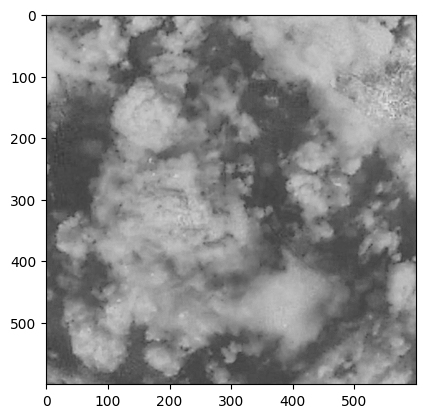

In [ ]:
map = gradient_maps[0]
print(len(map))
print(len(map[0]))
plt.imshow(augmented_image, cmap='gray')
plt.imshow(map, cmap='gray', alpha=0.5)
plt.show()

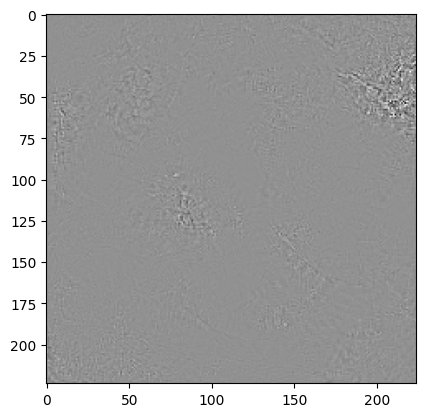

In [ ]:
plt.imshow(test2, cmap='jet', alpha=0.5)
plt.imshow(test1, cmap='gray')
plt.show()

### Remanent Tutorial Code for Identifying Green Pixels in Stock Image

Idea is to seperate cloud pixels from sky, exploratory extraction

In [5]:
# import cv2
# import numpy as np

# ## Read
# img = cv2.imread("sunflower.jpg")

# ## Convert to HSV
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# ## Mask of green (36,25,25) ~ (86, 255,255)
# # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
# mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

# ## Slice the green
# imask = mask>0
# green = np.zeros_like(img, np.uint8)
# green[imask] = img[imask]

# ## Save
# cv2.imwrite("green.png", green)

# # # Find all green pixels, i.e. where 100 < Hue < 140
# # lo,hi = 100,140
# # # Rescale to 0-255, rather than 0-360 because we are using uint8
# # lo = int((lo * 255) / 360)
# # hi = int((hi * 255) / 360)
# # green = np.where((H>lo) & (H<hi))

In [4]:
# import numpy as np
# from PIL import Image

# def identify_green_pixels(image_path, green_threshold=100):
#     """Identifies green pixels in an image.

#     Args:
#         image_path: Path to the image file.
#         green_threshold: Minimum green value to consider a pixel as green.

#     Returns:
#         A numpy array with the same shape as the image, where green pixels are marked as 1 and others as 0.
#     """

#     img = Image.open(image_path)
#     img_array = np.array(img)

#     # Extract the green channel
#     green_channel = img_array[:, :, 1]

#     # Create a mask for green pixels
#     green_mask = green_channel > green_threshold

#     return green_mask

# if __name__ == "__main__":
#     image_path = "your_image.jpg"
#     green_mask = identify_green_pixels(image_path)

#     # Display the green mask
#     import matplotlib.pyplot as plt
#     plt.imshow(green_mask, cmap='gray')
#     plt.show()

### Explore Shi-Tomasi Eigenvalue Comparison for "Corner" Pixel Identification

In [ ]:
import numpy as np

#https://www.cs.ucf.edu/courses/cap6411/cap6411/spring2006/shi_tomasi_94.pdf
#https://stackoverflow.com/questions/43527938/efficient-matlab-implementation-for-lukas-kanade-step

def is_good_pixel_for_lk(image, x, y, threshold = 0.01, window_size=12, draw_window=False):

    """
    Checks if a pixel is suitable for Lucas-Kanade optical flow tracking.

    Args:

        image: The grayscale image as a numpy array.

        x: The x-coordinate of the pixel.


        y: The y-coordinate of the pixel.

        window_size: The size of the window around the pixel to consider.

    Returns:

        True if the pixel is suitable, False otherwise.

    """

    # Check if the pixel is within the image boundaries

    if x < window_size // 2 or x >= image.shape[1] - window_size // 2 or y < window_size // 2 or y >= image.shape[0] - window_size // 2:
      return False

    # Extract the window around the pixel
    window = image[y - window_size // 2: y + window_size // 2 + 1, x - window_size // 2: x + window_size // 2 + 1]


    # Compute the eigenvalues of the structure tensor

    Ix = np.gradient(window, axis=1)
    Iy = np.gradient(window, axis=0)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    eigenvalues = np.linalg.eigvals(np.array([[Ixx.mean(), Ixy.mean()],

                                               [Ixy.mean(), Iyy.mean()]]))
    # Draw the window on the image if requested
    if draw_window:
        # Create a copy of the image to draw on
        image_with_window = image.copy()

        # Draw the window rectangle
        cv2.rectangle(image_with_window, (x - window_size // 2, y - window_size // 2), (x + window_size // 2, y + window_size // 2), (255, 0, 0), 2)  # Blue rectangle

        # Display the image with the window using matplotlib.pyplot
        plt.imshow(image_with_window, cmap='gray')
        plt.title('Image with Window')
        plt.show()

    # Check if both eigenvalues are large enough
    return min(eigenvalues) > threshold

60fps_v1/20170418/170418_175706_183328_frames/20170418_183050_frame_121440.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


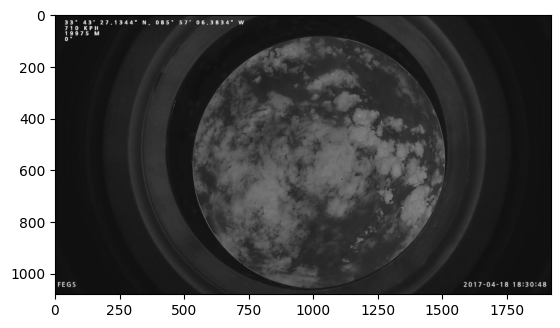

In [ ]:
# check point 1
# 18:13:50 x = 510 and y = 960
#full_df[full_df['Time']=="183050"].head()
frame_num = 121440

# Create a DataFrame from the image
img = get_image_from_blob(frame_num)

# displaying image
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
is_good_pixel_for_lk(img, x=510, y=960, window_size=12)

True

In [ ]:
# cannot do these until 60 fps processed for video 2
# manual_match_other_video = [("184125", 550, 980), ("185910", 560, 960), ("190940", 560, 960), ("191030", 530, 940), ("191055", 535, 940), ("191350", 550, 960)]

# for point in manual_HH_MM_match:
#   frame_num = full_df[full_df['Time_HH_MM']==point[0]]["frame_num"].iloc[0]
#   img = get_image_from_blob(frame_num)
#   print(is_good_pixel_for_lk(img, x=point[1], y=point[2], window_size=12))

In [ ]:
import numpy as np

def get_good_pixels_mask(image, window_size=12, threshold=0.01):
    """
    Iterates through all pixels in an image and gets an array of results
    from running the pixel through is_good_pixel_for_lk.

    Args:
        image: The grayscale image as a numpy array.
        window_size: The size of the window around the pixel to consider.

    Returns:
        A numpy array with the same shape as the image, where True indicates
        a good pixel for LK tracking and False indicates a bad pixel.
    """

    # Get image dimensions
    height, width = image.shape

    # Initialize the mask array
    good_pixels_mask = np.zeros_like(image, dtype=bool)

    # Iterate through all pixels
    for y in range(height):
        for x in range(width):
            # Check if the current pixel is good for LK tracking
            is_good = is_good_pixel_for_lk(image, x, y, threshold, window_size, draw_window=False)

            # Update the mask array
            good_pixels_mask[y, x] = is_good

    return good_pixels_mask

In [ ]:
# check chandrakant's points
manual_points = [("183050", 510, 960), ("181810", 540, 960), ("181920", 500, 960), ("182455", 509, 950), ("182740", 510, 1000)]

for point in manual_points:
  frame_num = full_df[full_df['Time']==point[0]]["frame_num"].iloc[0]
  img = get_image_from_blob(frame_num)
  print(is_good_pixel_for_lk(img, x=point[1], y=point[2], window_size=12))

60fps_v1/20170418/170418_175706_183328_frames/20170418_183050_frame_121440.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


True
60fps_v1/20170418/170418_175706_183328_frames/20170418_181810_frame_75840.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_181920_frame_80040.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182455_frame_100140.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182740_frame_110040.jpg
True


60fps_v1/20170418/170418_175706_183328_frames/20170418_183050_frame_121440.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


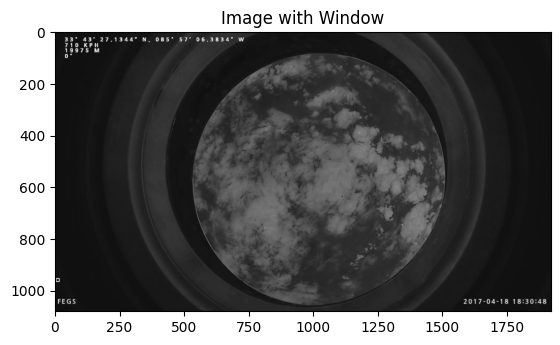

True

In [ ]:
frame_num = 121440
img = get_image_from_blob(frame_num)
is_good_pixel_for_lk(img, x=10, y=960, window_size=12, draw_window=True)

In [ ]:
arr = get_good_pixels_mask(img, window_size=12)

In [ ]:
import numpy
a = numpy.asarray(arr)
numpy.savetxt("foo.csv", a, delimiter=",")

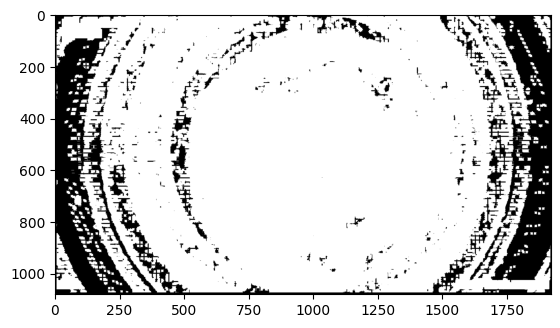

In [ ]:
import matplotlib.pyplot as plt

def display_array_as_image(array):
    """Displays a NumPy array as an image with 0 as black and 1 as white.

    Args:
        array: The NumPy array to display.
    """

    plt.imshow(array, cmap='gray')  # Use 'gray' colormap for black and white
    plt.show()
display_array_as_image(arr)

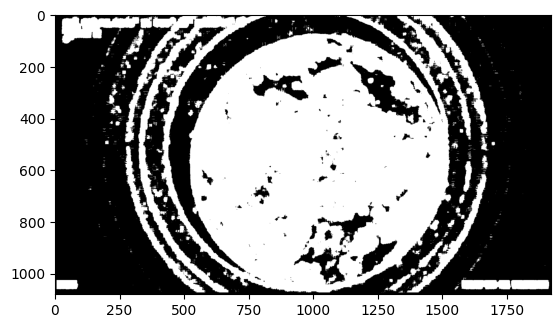

In [ ]:
# test higher threshold 0.2
arr2 = get_good_pixels_mask(img, window_size=12, threshold=0.2)
display_array_as_image(arr2)

In [ ]:
manual_points = [("183050", 510, 960), ("181810", 540, 960), ("181920", 500, 960), ("182455", 509, 950), ("182740", 510, 1000)]

#threshold increase 0.2
for point in manual_points:
  frame_num = full_df[full_df['Time']==point[0]]["frame_num"].iloc[0]
  img = get_image_from_blob(frame_num)
  print(is_good_pixel_for_lk(img, x=point[1], y=point[2], window_size=12, threshold=0.2))

60fps_v1/20170418/170418_175706_183328_frames/20170418_183050_frame_121440.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


True
60fps_v1/20170418/170418_175706_183328_frames/20170418_181810_frame_75840.jpg
False
60fps_v1/20170418/170418_175706_183328_frames/20170418_181920_frame_80040.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182455_frame_100140.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182740_frame_110040.jpg
False


In [ ]:
manual_points = [("183050", 510, 960), ("181810", 540, 960), ("181920", 500, 960), ("182455", 509, 950), ("182740", 510, 1000)]

for point in manual_points:
  frame_num = full_df[full_df['Time']==point[0]]["frame_num"].iloc[0]
  img = get_image_from_blob(frame_num)
  print(is_good_pixel_for_lk(img, x=point[1], y=point[2], window_size=12, threshold=0.07))

60fps_v1/20170418/170418_175706_183328_frames/20170418_183050_frame_121440.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


True
60fps_v1/20170418/170418_175706_183328_frames/20170418_181810_frame_75840.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_181920_frame_80040.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182455_frame_100140.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182740_frame_110040.jpg
True


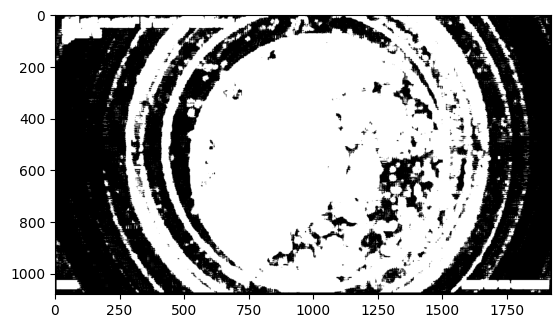

In [ ]:
# test higher threshold 0.07
arr3 = get_good_pixels_mask(img, window_size=12, threshold=0.07)
display_array_as_image(arr3)

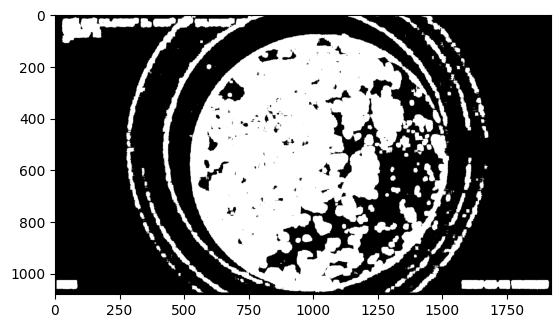

In [ ]:
# test higher threshold 0.5
arr4 = get_good_pixels_mask(img, window_size=12, threshold=0.5)
display_array_as_image(arr4)

In [ ]:
manual_points = [("183050", 510, 960), ("181810", 540, 960), ("181920", 500, 960), ("182455", 509, 950), ("182740", 510, 1000)]

for point in manual_points:
  frame_num = full_df[full_df['Time']==point[0]]["frame_num"].iloc[0]
  img = get_image_from_blob(frame_num)
  print(is_good_pixel_for_lk(img, x=point[1], y=point[2], window_size=12, threshold=0.5))

60fps_v1/20170418/170418_175706_183328_frames/20170418_183050_frame_121440.jpg


<ipython-input-58-65865483b19c>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(blob, dtype='uint8')


True
60fps_v1/20170418/170418_175706_183328_frames/20170418_181810_frame_75840.jpg
False
60fps_v1/20170418/170418_175706_183328_frames/20170418_181920_frame_80040.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182455_frame_100140.jpg
True
60fps_v1/20170418/170418_175706_183328_frames/20170418_182740_frame_110040.jpg
False


In [ ]:
blobpath = "60fps_v1/20170418/full_df.csv"
client = BlobClient.from_connection_string(connection_string, container_name, blobpath)
blob = client.download_blob()
full_df = pd.read_csv(blob)

In [ ]:
full_df.shape

(131044, 52)

In [ ]:
full_df.dropna(subset=['Pitch', 'Grnd_Spd', 'GPS_MSL_Alt', 'top_height'], inplace=True)
full_df['DateTime_UTC'] = pd.to_datetime(full_df['DateTime_UTC'], infer_datetime_format=True)
full_df['DateTime_UTC'].head()

<ipython-input-114-65b67a874f35>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  full_df['DateTime_UTC'] = pd.to_datetime(full_df['DateTime_UTC'], infer_datetime_format=True)


180   2017-04-18 17:57:09.004
181   2017-04-18 17:57:09.004
182   2017-04-18 17:57:09.004
183   2017-04-18 17:57:09.004
184   2017-04-18 17:57:09.004
Name: DateTime_UTC, dtype: datetime64[ns]

In [ ]:
truth_df = full_df[full_df['top_height'].notna()]
print("size_before", truth_df.shape)
truth_df = truth_df.loc[truth_df.groupby('timestamp_y')['DateTime_UTC'].idxmin()] # take first frame aggregated at seconds level (not millisecond resolution)
print("size_after", truth_df.shape)
truth_frames = truth_df.frame_num
truth_df.head()

size_before (25864, 52)
size_after (432, 52)


Unnamed: 0                 frames_filename  frame_num      Date    Time  \
180          180   20170418_175709_frame_180.jpg        180  20170418  175709   
480          480   20170418_175714_frame_480.jpg        480  20170418  175714   
780          780   20170418_175719_frame_780.jpg        780  20170418  175719   
1080        1080  20170418_175724_frame_1080.jpg       1080  20170418  175724   
1380        1380  20170418_175729_frame_1380.jpg       1380  20170418  175729   

                 DateTime Short_Name            DateTime_UTC        Lat  \
180   2017-04-18 17:57:09       IWG1 2017-04-18 17:57:09.004  34.610995   
480   2017-04-18 17:57:14       IWG1 2017-04-18 17:57:14.004  34.620100   
780   2017-04-18 17:57:19       IWG1 2017-04-18 17:57:19.004  34.629211   
1080  2017-04-18 17:57:24       IWG1 2017-04-18 17:57:24.004  34.638317   
1380  2017-04-18 17:57:29       IWG1 2017-04-18 17:57:29.004  34.647425   

            Lon  ...      lat      lon      alt  angle    N     GH  \
180  -86.583988  ...  34.6076 -86.5841  19966.0   1.05  2.0 -999.0   
480  -86.583985  ...  34.6167 -86.5841  19966.0   1.12  2.0 -999.0   
780  -86.583980  ...  34.6258 -86.5841  19966.0   1.12  4.0  210.0   
1080 -86.583978  ...  34.6349 -86.5841  19966.0   1.10  3.0  210.0   
1380 -86.583978  ...  34.6440 -86.5841  19966.0   1.19  2.0  210.0   

      top_height  bottom_height  layer_discriminator  angle_diff_to_prev  
180      13161.0         9953.0                  3.0               -0.04  
480      13131.0        10013.0                  3.0                0.07  
780      13161.0         9833.0                  3.0                0.00  
1080     13191.0         9923.0                  3.0               -0.02  
1380     13161.0        10133.0                  3.0                0.09  

[5 rows x 52 columns]

In [1]:
# result_df = pd.read_csv("results_max2.csv")
# result_df.head()

In [2]:
# final = pd.merge(result_df, truth_df, left_on='frame_num', right_on='frame_num', how='left')
# final = final[['frame_num', 'max_point', 'min_eigen', 'height_matrix', 'top_height', 'DateTime', 'frames_filename']]

In [3]:
# final.to_csv("final.csv", index=False)